In [1]:
import io
import sys
PATH = '/home/epuerta/Academic/AI_DataAnalytics/SLF4SA/'
DIR_DATA = '../Academic/AI_DataAnalytics/SLF4SA/data/input/'
sys.path.append(PATH) if PATH not in list(sys.path) else None
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing

from sklearn.pipeline import FeatureUnion
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler


from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, precision_score

from logic.utils import Utils
from logic.classifiers import Classifiers
from logic.text_processing import TextProcessing
from logic.lexical_vectorizer import LexicalVectorizer
from root import DIR_RESULTS

# Variable initialization 

In [2]:
lang = 'es'
iteration = 10
fold = 10
classifiers = Classifiers.dict_classifiers
tp = TextProcessing(lang=lang)
lv = LexicalVectorizer(lang=lang, text_processing=tp)
ut = Utils(lang=lang, text_processing=tp)

# Import data

In [3]:
print('+ Import training...')
x, y = ut.get_data(file_name='tass2020_emotion_train')
print('+ Import test...')
x_eval, y_eval = ut.get_data(file_name='tass2020_emotion_dev')

+ Import training...
		 - Dataset size :(x: 5886 , y: 5886)
+ Import test...
		 - Dataset size :(x: 857 , y: 857)


# Feature extraction

In [4]:
bow_vector = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=10)
preprocessor = FeatureUnion([('bow_vector', bow_vector), ('lex_vector', lv)])
preprocessor.fit(x)
x = preprocessor.transform(x)

print('- train:\n', sorted(Counter(y).items()))

- train:
 [('anger ', 600), ('disgust ', 113), ('fear ', 67), ('joy ', 1270), ('others ', 2889), ('sadness ', 706), ('surprise ', 241)]


# Over Sampling

In [5]:
k_fold = ShuffleSplit(n_splits=fold, test_size=0.25, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=42)
ros_train = RandomOverSampler(random_state=1000)
x_train, y_train = ros_train.fit_resample(x_train, y_train)
x_test, y_test = ros_train.fit_resample(x_test, y_test)
print('- train:\n', sorted(Counter(y_train).items()))
print('- test:\n', sorted(Counter(y_test).items()))

- train:
 [('anger ', 2023), ('disgust ', 2023), ('fear ', 2023), ('joy ', 2023), ('others ', 2023), ('sadness ', 2023), ('surprise ', 2023)]
- test:
 [('anger ', 866), ('disgust ', 866), ('fear ', 866), ('joy ', 866), ('others ', 866), ('sadness ', 866), ('surprise ', 866)]


In [6]:
shape = x_train.shape[1:]
shape

(1041,)

In [7]:
lb = LabelEncoder()
y_train = lb.fit_transform([i.rstrip() for i in y_train.to_list()])
y_eval = lb.transform([i.rstrip() for i in y_eval.to_list()])
y_test = lb.transform([i.rstrip() for i in y_test.to_list()])

# NN Architecture

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.Input(shape=shape),
                                 keras.layers.Dense(600, activation="relu"),
                                 keras.layers.Dense(300, activation="relu"),
                                 keras.layers.Dense(150, activation="relu"),
                                 keras.layers.Dense(7, activation="softmax")
                                ])
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               625200    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1057      
Total params: 851,707
Trainable params: 851,707
Non-trainable params: 0
_________________________________________________________________


# Training

Epoch 1/100
443/443 [==============================] - 4s 9ms/step - loss: 1.9313 - accuracy: 0.1986 - val_loss: 1.9318 - val_accuracy: 0.1915
Epoch 2/100
443/443 [==============================] - 4s 8ms/step - loss: 1.8979 - accuracy: 0.2954 - val_loss: 1.9170 - val_accuracy: 0.2123
Epoch 3/100
443/443 [==============================] - 4s 8ms/step - loss: 1.8518 - accuracy: 0.3669 - val_loss: 1.8928 - val_accuracy: 0.2278
Epoch 4/100
443/443 [==============================] - 4s 8ms/step - loss: 1.7715 - accuracy: 0.4305 - val_loss: 1.8557 - val_accuracy: 0.2639
Epoch 5/100
443/443 [==============================] - 4s 8ms/step - loss: 1.6321 - accuracy: 0.4856 - val_loss: 1.8016 - val_accuracy: 0.2836
Epoch 6/100
443/443 [==============================] - 4s 8ms/step - loss: 1.4458 - accuracy: 0.5353 - val_loss: 1.7871 - val_accuracy: 0.3045
Epoch 7/100
443/443 [==============================] - 4s 8ms/step - loss: 1.2579 - accuracy: 0.5884 - val_loss: 1.8230 - val_accuracy: 0.3075

Epoch 58/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0877 - accuracy: 0.9742 - val_loss: 6.6449 - val_accuracy: 0.2887
Epoch 59/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0823 - accuracy: 0.9754 - val_loss: 6.6683 - val_accuracy: 0.2946
Epoch 60/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0826 - accuracy: 0.9764 - val_loss: 7.2517 - val_accuracy: 0.2855
Epoch 61/100
443/443 [==============================] - 4s 9ms/step - loss: 0.0812 - accuracy: 0.9752 - val_loss: 6.6898 - val_accuracy: 0.2933
Epoch 62/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0797 - accuracy: 0.9756 - val_loss: 6.5419 - val_accuracy: 0.2895
Epoch 63/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0789 - accuracy: 0.9774 - val_loss: 7.3626 - val_accuracy: 0.2801
Epoch 64/100
443/443 [==============================] - 4s 8ms/step - loss: 0.0804 - accuracy: 0.9758 - val_loss: 6.5734 - val_accuracy:

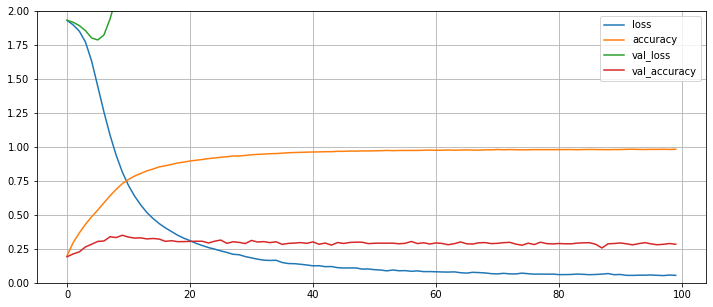

In [12]:
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

pd.DataFrame(history.history).plot(figsize=(12, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [13]:
score = model.evaluate(x_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

y_predict = []
for features in tqdm(x_test):
    features = features.reshape(1, -1)
    value_prob = model.predict(features)
    value = np.argmax(value_prob, axis=1)
    y_predict.append(value)

accuracy_predict = accuracy_score(y_test, y_predict)
print('Accuracy: {0}'.format(round(np.mean(accuracy_predict), 2)))
print(classification_report(y_test, y_predict))

190/190 [==============================] - 0s 2ms/step - loss: 8.3127 - accuracy: 0.2836


0it [00:00, ?it/s]

Test Score: 8.312726974487305
Test Accuracy: 0.2835697829723358


6062it [01:17, 78.06it/s] 


Accuracy: 0.28
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       866
           1       0.00      0.00      0.00       866
           2       0.00      0.00      0.00       866
           3       0.32      0.44      0.37       866
           4       0.19      0.69      0.29       866
           5       0.56      0.47      0.51       866
           6       0.30      0.13      0.18       866

    accuracy                           0.28      6062
   macro avg       0.26      0.28      0.24      6062
weighted avg       0.26      0.28      0.24      6062

